# Capstone Project IBM 
## Museums and Hotels in Sankt-Petersburg
### Author: Vdovenko Anton

### Introduction to Business problem

Sankt-Petersburg is a unique tourist city. It has one of, top 3 biggest Museums in the World – the Hermitage, as well as a whole bunch different museums and cultural centers(over 150). In 2018  there were 8,2 million tourists and the number rises every year. At the same time traveling around the city for non-local may be challenging, so right hotel location is the key to success.  

In this project, we will try to find an optimal location for a hotel. We will spot all the museums on the map and made a cluster analysis. After that we will look for location closest to cluster centers and at the same time with lowest hotel density.  

Thie report is useful for both tourist and business stakeholders.


### Data Description

Based on the definition of our problem, the factors that will influence our decision are:

* number of museums
* location of Cultural Cluster Centers
* top venues for each Cultural Cluster Centers

Following data sources will be needed to extract/generate the required information:

* Wiki page to find all Sankt-Petersburg museums
* Geocoder to find Longitude and Latitude based on museums addresses
* Foursquare API to find venues near the Cultural Cluster Centers
* Latitude and Lotitude from Google Maps


### Part 1 Getting and Cleaning Data

In [2]:
# DF tools
import pandas as pd
import numpy as np

#json tools
import json
from pandas.io.json import json_normalize

#scraping
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup

#geocoders
from geopy.geocoders import Nominatim

#visualization libraries
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium

#kmeans clustering
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

print('All libraries are set!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

#### Lets take data of museums from wiki page and make Data Frame out of it

In [3]:
# A link to wiki page
link_2 = 'https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%B7%D0%B5%D0%B8_%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0'

# We are slicing into distinct DF our wiki page manualy becouse looping takes resources and IBM Watson get stuck

df_1 = pd.read_html(link_2)[1]
df_2 = pd.read_html(link_2)[2]
df_3 = pd.read_html(link_2)[3]
df_4 = pd.read_html(link_2)[4]
df_5 = pd.read_html(link_2)[5]
df_6 = pd.read_html(link_2)[6]
df_7 = pd.read_html(link_2)[7]
df_8 = pd.read_html(link_2)[8]
df_9 = pd.read_html(link_2)[9]
df_10 = pd.read_html(link_2)[10]
df_11 = pd.read_html(link_2)[11]
df_12 = pd.read_html(link_2)[12]
df_13 = pd.read_html(link_2)[13]


In [4]:
# Lets join our DF into one 
df_a = pd.concat([df_1,df_2,df_3,df_4,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,df_13])
print(df_a.shape)
df_a.head()


(175, 5)


,Название,Адрес,Дата открытия,Описание экспозиции,Изображение
0,Государственный Эрмитаж[2],"Дворцовая площадь, 2",1764 год[3],Экспозиция музея показывает развитие мирового ...,NaN
1,Зимний дворец Петра I[2] (филиал Государственн...,"Дворцовая набережная, 32",1992 год,Уникальный архитектурно-мемориальный памятник ...,NaN
2,Меншиковский дворец[2] (филиал Государственног...,"Университетская набережная, 15",1981 год,"В экспозицию входят произведения искусства, пр...",NaN
3,Музей Императорского фарфорового завода[2] (фи...,"проспект Обуховской Обороны, 151",2003 год,Этапы развития первого отечественного фарфоров...,NaN
4,Восточное крыло здания Главного штаба[2] (фили...,"Дворцовая площадь, 6",2010 год,Экспозиция оформляется,NaN


#### Now we need to clean the data and find Longtitude and Latitude for Museums Address

In [5]:
# Reset index
df_a.reset_index(inplace=True)


In [6]:
# Drop extra columns 

df_a.drop(['index','Изображение'],axis=1,inplace=True)
df_a

# Дата открытия = Year of establishment
# Описание экспозиции = Description of Museum

,Название,Адрес,Дата открытия,Описание экспозиции
0,Государственный Эрмитаж[2],"Дворцовая площадь, 2",1764 год[3],Экспозиция музея показывает развитие мирового ...
1,Зимний дворец Петра I[2] (филиал Государственн...,"Дворцовая набережная, 32",1992 год,Уникальный архитектурно-мемориальный памятник ...
2,Меншиковский дворец[2] (филиал Государственног...,"Университетская набережная, 15",1981 год,"В экспозицию входят произведения искусства, пр..."
3,Музей Императорского фарфорового завода[2] (фи...,"проспект Обуховской Обороны, 151",2003 год,Этапы развития первого отечественного фарфоров...
4,Восточное крыло здания Главного штаба[2] (фили...,"Дворцовая площадь, 6",2010 год,Экспозиция оформляется
5,Государственный Русский музей[4],"Инженерная улица, 4",1898 год,Экспозиция охватывает все исторические периоды...
6,Мраморный дворец[4] (филиал Государственного Р...,"Миллионная улица, 5/1",1995 год,Развёрнуты постоянные экспозиции — «Музей Людв...
7,Инженерный (Михайловский) замок[4] (филиал Гос...,"Садовая улица, 2",1991 год,Развёрнуты постоянные экспозиции — «История за...
8,Строгановский дворец[4] (филиал Государственно...,"Невский проспект, 17",2003 год,Экспозиция «Семейные реликвии и вклады рода Ст...
9,Летний сад[4] (филиал Государственного Русског...,остров Летний сад,1704 год,С коллекцией скульптуры и Летний дворец Петра ...


In [7]:
df_a.tail()

,Название,Адрес,Дата открытия,Описание экспозиции
170,Выставочный зал Правительства Ленинградской об...,"улица Смольного, 3",2000 год,В здании б. Мещанского училища проводятся выст...
171,Арт-галерея «АРКА»[121],"Большая Морская улица, 6",2004 год,Тематические и персональные выставки проводятс...
172,Галерея ART re.FLEX[122],"проспект Бакунина, 5",2006 год,Галерея работает с петербургскими и московским...
173,Арт-Центр «Перинные Ряды»[123],"Думская улица, 4",2010 год,Галерея представляет собой выставочную площадк...
174,Выставочный центр «Ткачи»[124],"набережная Обводного канала, 60",2010 год,"Многофункциональный центр для культуры, образо..."


In [8]:
# Now lets find address of Museums
y = list()
z = list()
x = 0
while x <=100:
    try:
        address = df_a.loc[x,'Адрес']
        x = x + 1
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        y.append(latitude)
        z.append(longitude)
    except:
        y.append(0)
        z.append(0)



In [9]:
# We are doing it in two cells because there is a limit of requests 
while x <=174:
    try:
        address = df_a.loc[x,'Адрес']
        x = x + 1
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        y.append(latitude)
        z.append(longitude)
    except:
        y.append(0)
        z.append(0)
len(y)

175

In [10]:
#Create DF for Latitude and Longtitude
d = {'Latitude':y,'Longtitude':z}
df = pd.DataFrame(data=d)
df.tail()

,Latitude,Longtitude
170,59.950797,30.396613
171,44.609977,33.520512
172,59.929819,30.374158
173,59.933748,30.328989
174,59.909407,30.320896


In [11]:
# Merge our museum DF and location DF into one
df_a1 = pd.merge(df_a,df,right_index=True,left_index=True)
df_a1.tail()

,Название,Адрес,Дата открытия,Описание экспозиции,Latitude,Longtitude
170,Выставочный зал Правительства Ленинградской об...,"улица Смольного, 3",2000 год,В здании б. Мещанского училища проводятся выст...,59.950797,30.396613
171,Арт-галерея «АРКА»[121],"Большая Морская улица, 6",2004 год,Тематические и персональные выставки проводятс...,44.609977,33.520512
172,Галерея ART re.FLEX[122],"проспект Бакунина, 5",2006 год,Галерея работает с петербургскими и московским...,59.929819,30.374158
173,Арт-Центр «Перинные Ряды»[123],"Думская улица, 4",2010 год,Галерея представляет собой выставочную площадк...,59.933748,30.328989
174,Выставочный центр «Ткачи»[124],"набережная Обводного канала, 60",2010 год,"Многофункциональный центр для культуры, образо...",59.909407,30.320896


In [12]:
# There are 33 Museums out of 175 Nominatum failed to append Latitude and longtitude
df_a1[df_a1['Latitude']==0].shape

(32, 6)

In [13]:
df_a1[df_a1['Latitude']==0].head(2)


,Название,Адрес,Дата открытия,Описание экспозиции,Latitude,Longtitude
13,Музей-усадьба И. Е. Репина «Пенаты»[6] (филиал...,"поселок Репино, Приморское шоссе, 411",1940 год,В экспозиции можно видеть личные вещи художник...,0.0,0.0
15,Музей-квартира А. И. Куинджи[6] (филиал Музея ...,"Биржевой переулок, 1/10, квартира 11",1992 год,"Экспозиция воссоздаёт атмосферу, долгие годы о...",0.0,0.0


In [14]:
# Lets manually add Museums coordinates
df_a1.loc[7,'Latitude'] = 59.940259
df_a1.loc[7,'Longtitude'] = 30.337350

df_a1.loc[13,'Latitude'] = 60.132570
df_a1.loc[13,'Longtitude'] = 29.941880

df_a1.loc[15,'Latitude'] = 59.945300
df_a1.loc[15,'Longtitude'] = 30.293240

df_a1.loc[17,'Latitude'] = 59.929450
df_a1.loc[17,'Longtitude'] = 30.357020

df_a1.loc[18,'Latitude'] = 59.933240
df_a1.loc[18,'Longtitude'] = 30.251090

df_a1.loc[19,'Latitude'] = 59.937390
df_a1.loc[19,'Longtitude'] = 30.284960

df_a1.loc[25,'Latitude'] = 59.932460
df_a1.loc[25,'Longtitude'] = 30.351900

df_a1.loc[29,'Latitude'] = 59.936820
df_a1.loc[29,'Longtitude'] = 30.265590

df_a1.loc[35,'Latitude'] = 59.943090
df_a1.loc[35,'Longtitude'] = 30.267560

df_a1.loc[36,'Latitude'] = 59.931170
df_a1.loc[36,'Longtitude'] = 30.236430

df_a1.loc[40,'Latitude'] = 59.939570
df_a1.loc[40,'Longtitude'] = 30.290200

df_a1.loc[41,'Latitude'] = 59.944770
df_a1.loc[41,'Longtitude'] = 30.394210

df_a1.loc[49,'Latitude'] = 59.937180
df_a1.loc[49,'Longtitude'] = 30.346110

df_a1.loc[54,'Latitude'] = 59.937920
df_a1.loc[54,'Longtitude'] = 30.326140

df_a1.loc[58,'Latitude'] = 59.717420
df_a1.loc[58,'Longtitude'] = 30.397770

df_a1.loc[89,'Latitude'] = 59.934030
df_a1.loc[89,'Longtitude'] = 30.330450

df_a1.loc[90,'Latitude'] = 59.945660
df_a1.loc[90,'Longtitude'] = 30.390260

df_a1.loc[91,'Latitude'] = 59.873290
df_a1.loc[91,'Longtitude'] = 29.842620

df_a1.loc[92,'Latitude'] = 59.936050
df_a1.loc[92,'Longtitude'] = 30.381360

df_a1.loc[98,'Latitude'] = 59.926710
df_a1.loc[98,'Longtitude'] = 30.280510

df_a1.loc[100,'Latitude'] = 59.929280
df_a1.loc[100,'Longtitude'] = 30.328480

df_a1.loc[106,'Latitude'] = 59.940490
df_a1.loc[106,'Longtitude'] = 30.289400

df_a1.loc[113,'Latitude'] = 59.955350
df_a1.loc[113,'Longtitude'] = 30.294390

df_a1.loc[132,'Latitude'] = 60.079670
df_a1.loc[132,'Longtitude'] = 29.977490

df_a1.loc[138,'Latitude'] = 59.685560
df_a1.loc[138,'Longtitude'] = 30.446440

df_a1.loc[142,'Latitude'] = 59.883250
df_a1.loc[142,'Longtitude'] = 29.913590

df_a1.loc[143,'Latitude'] = 59.884370
df_a1.loc[143,'Longtitude'] = 29.907690

df_a1.loc[144,'Latitude'] = 59.884369
df_a1.loc[144,'Longtitude'] = 29.907690

df_a1.loc[145,'Latitude'] = 59.884369
df_a1.loc[145,'Longtitude'] = 29.907690

df_a1.loc[152,'Latitude'] = 59.931410
df_a1.loc[152,'Longtitude'] = 30.239920

df_a1.loc[155,'Latitude'] = 59.928630
df_a1.loc[155,'Longtitude'] = 30.268590

df_a1.loc[157,'Latitude'] = 59.950460
df_a1.loc[157,'Longtitude'] = 30.314230

df_a1.loc[164,'Latitude'] = 59.926210
df_a1.loc[164,'Longtitude'] = 30.239810


In [15]:
# Lets check either or not we have 0 values
df_a1[df_a1['Latitude']==0].shape

(0, 6)

In [16]:
df_a1.rename(columns={'Название':'Name','Адрес':'Address','Дата открытия':'Date of establishment','Описание экспозиции':'Museum Description'}, inplace = True)
df_a1.head(2)

,Name,Address,Date of establishment,Museum Description,Latitude,Longtitude
0,Государственный Эрмитаж[2],"Дворцовая площадь, 2",1764 год[3],Экспозиция музея показывает развитие мирового ...,52.247938,21.013794
1,Зимний дворец Петра I[2] (филиал Государственн...,"Дворцовая набережная, 32",1992 год,Уникальный архитектурно-мемориальный памятник ...,59.942635,30.317757


In [17]:
#Now lets manually fix mistakes and outliers
df_a1[df_a1['Longtitude']<=29]

,Name,Address,Date of establishment,Museum Description,Latitude,Longtitude
0,Государственный Эрмитаж[2],"Дворцовая площадь, 2",1764 год[3],Экспозиция музея показывает развитие мирового ...,52.247938,21.013794
39,Метрологический музей ГОССТАНДАРТА России при ...,"Московский проспект, 19",1928 год,"Экспозиция, расположенная в последней квартире...",54.704254,20.596903
75,Музей «Ниеншанц»[48],"Английская набережная, 6",2003 год,"Экспозиция состоит из памятников археологии, о...",43.686057,7.237364
78,Особняк Румянцева[19](филиал Государственного ...,"Английская набережная, 44",1946 год,Экспозиции «Особняк Румянцева. История здания ...,43.681270,7.232093
161,Гранд Макет Россия[112],"Цветочная улица, 16",2012 год,На макетном поле площадью почти 800 м² объедин...,57.748701,28.407010


In [18]:
df_a1.loc[0,'Latitude'] = 59.938310
df_a1.loc[0,'Longtitude'] = 30.315000

df_a1.loc[39,'Latitude'] = 59.917190
df_a1.loc[39,'Longtitude'] = 30.313410

df_a1.loc[75,'Latitude'] = 59.935580
df_a1.loc[75,'Longtitude'] = 30.298640

df_a1.loc[78,'Latitude'] = 59.932780
df_a1.loc[78,'Longtitude'] = 30.289300

df_a1.loc[161,'Latitude'] = 59.887420
df_a1.loc[161,'Longtitude'] = 30.331100

In [19]:
df_a1[df_a1['Longtitude']>=31]

,Name,Address,Date of establishment,Museum Description,Latitude,Longtitude
5,Государственный Русский музей[4],"Инженерная улица, 4",1898 год,Экспозиция охватывает все исторические периоды...,52.354164,104.222508
8,Строгановский дворец[4] (филиал Государственно...,"Невский проспект, 17",2003 год,Экспозиция «Семейные реликвии и вклады рода Ст...,67.371978,32.508282
20,Музей прикладного искусства Санкт-Петербургско...,"Соляной переулок, 13-15",1878 год,В собрании музея представлены образцы русского...,51.152872,54.992042
21,Галерея «Петербургский центр искусств»[12],"площадь Труда, 3",2010 год,Экспозиция ориентирована на мастерство и извес...,54.986006,60.105065
24,Галерея современной скульптуры и пластики[15],"улица Маршала Тухачевского, 27/2",2009 год,"Галерея, которая знакомит публику с искусством...",55.783107,37.479324
31,Российский государственный музей Арктики и Ант...,"улица Марата, 24а",1930 год,"В музее проводятся экскурсии, посвящённые прир...",56.854187,60.547164
50,Мемориальный музей-квартира Л.Н.Гумилёва[35] (...,"Коломенская улица, 1/15",2003 год,"Квартира известного ученого — историка, геогра...",54.426577,86.296358
53,Литературно-мемориальный музей Ф. М. Достоевск...,"Кузнечный переулок, 5/2",1971 год,Музей состоит из мемориальной квартиры Ф.М.Дос...,42.891629,74.641362
56,Музей-квартира А. А. Блока[19] (филиал Государ...,"улица Декабристов, 57",1980 год,Музей состоит из мемориальной квартиры с подли...,58.189948,68.255113
61,Мемориальный музей-квартира семьи актеров Само...,"Стремянная улица, 8",1994 год,"Экспозиция, посвящённая петербургской театраль...",51.789465,55.219890


In [20]:
df_a1.loc[5,'Latitude'] = 59.938730
df_a1.loc[5,'Longtitude'] = 30.332390

df_a1.loc[8,'Latitude'] = 59.935800
df_a1.loc[8,'Longtitude'] = 30.320610

df_a1.loc[20,'Latitude'] = 59.943000
df_a1.loc[20,'Longtitude'] = 30.340760

df_a1.loc[21,'Latitude'] = 59.931870
df_a1.loc[21,'Longtitude'] = 30.292310

df_a1.loc[24,'Latitude'] = 59.969800
df_a1.loc[24,'Longtitude'] = 30.424740

df_a1.loc[31,'Latitude'] = 59.922960
df_a1.loc[31,'Longtitude'] = 30.346040

df_a1.loc[50,'Latitude'] = 59.926794
df_a1.loc[50,'Longtitude'] = 30.354918

df_a1.loc[53,'Latitude'] = 59.927271
df_a1.loc[53,'Longtitude'] = 30.350475

df_a1.loc[56,'Latitude'] = 59.923924
df_a1.loc[56,'Longtitude'] = 30.282944

df_a1.loc[61,'Latitude'] = 59.931384
df_a1.loc[61,'Longtitude'] = 30.350546

df_a1.loc[68,'Latitude'] = 59.931384
df_a1.loc[68,'Longtitude'] = 30.350546

df_a1.loc[74,'Latitude'] = 59.937941
df_a1.loc[74,'Longtitude'] = 30.334755

df_a1.loc[76,'Latitude'] = 59.931753
df_a1.loc[76,'Longtitude'] = 30.301198

df_a1.loc[81,'Latitude'] = 59.901859
df_a1.loc[81,'Longtitude'] = 30.282959

df_a1.loc[83,'Latitude'] = 59.954738
df_a1.loc[83,'Longtitude'] = 30.325076

df_a1.loc[85,'Latitude'] = 60.001272
df_a1.loc[85,'Longtitude'] = 30.354527

df_a1.loc[95,'Latitude'] = 59.944531
df_a1.loc[95,'Longtitude'] = 30.340745

df_a1.loc[101,'Latitude'] = 59.930652
df_a1.loc[101,'Longtitude'] = 30.293091

df_a1.loc[133,'Latitude'] = 59.844018
df_a1.loc[133,'Longtitude'] = 30.320408

df_a1.loc[147,'Latitude'] = 59.860454
df_a1.loc[147,'Longtitude'] = 30.047205

df_a1.loc[148,'Latitude'] = 59.932788
df_a1.loc[148,'Longtitude'] = 30.301973

df_a1.loc[151,'Latitude'] = 59.924584
df_a1.loc[151,'Longtitude'] = 30.313517

df_a1.loc[156,'Latitude'] = 59.948407
df_a1.loc[156,'Longtitude'] = 30.235360

df_a1.loc[159,'Latitude'] = 59.965354
df_a1.loc[159,'Longtitude'] = 30.315603

df_a1.loc[169,'Latitude'] = 59.933279
df_a1.loc[169,'Longtitude'] = 30.311404

df_a1.loc[171,'Latitude'] = 59.937367
df_a1.loc[171,'Longtitude'] = 30.317957

df_a1.loc[30,'Latitude'] = 59.932521
df_a1.loc[30,'Longtitude'] = 30.310412

df_a1.loc[125,'Latitude'] = 59.932521
df_a1.loc[125,'Longtitude'] = 30.310412



In [21]:
# Now lets check on NaN
df_a1.isnull().values.any()


True

In [22]:
# Lets fix NaN date
df_a1[df_a1['Date of establishment'].isnull()]
df_a1.loc[46,'Date of establishment'] = 1958

In [23]:
# Lets make Date int
df_s = df_a1['Date of establishment'].str.split(" ", n = 1, expand = True)
df_a1['Date of establishment'] = df_s[0]
df_a1.head(2)


,Name,Address,Date of establishment,Museum Description,Latitude,Longtitude
0,Государственный Эрмитаж[2],"Дворцовая площадь, 2",1764,Экспозиция музея показывает развитие мирового ...,59.938310,30.315000
1,Зимний дворец Петра I[2] (филиал Государственн...,"Дворцовая набережная, 32",1992,Уникальный архитектурно-мемориальный памятник ...,59.942635,30.317757


In [24]:
# Lets make Date int
df_a1.loc[94,'Date of establishment'] = 1990
df_a1.loc[46,'Date of establishment'] = 1958
df_a1.loc[100,'Date of establishment'] = 1731
df_a1.loc[115,'Date of establishment'] = 2003
pd.to_numeric(df_a1['Date of establishment'])
df_a1['Date of establishment'] = df_a1['Date of establishment'].astype(int)
df_a1.dtypes

Name                      object
Address                   object
Date of establishment      int64
Museum Description        object
Latitude                 float64
Longtitude               float64
dtype: object

In [26]:
# Now lets drop duplicates if any
df_a1.drop_duplicates(subset ="Name",keep = False, inplace = True)
df_a1.shape
df_a1.reset_index(inplace=True)
df_a1.head()
df_a1.drop(columns=['index','level_0'],inplace=True,axis=1)
# Even though there is a duplicates in Address, there are different museums 

In [27]:
# Finally lets name our clean and full data frame meaningfully
df_m = df_a1 
# df_m m = museums
df_m.head(2)


,Name,Address,Date of establishment,Museum Description,Latitude,Longtitude
0,Государственный Эрмитаж[2],"Дворцовая площадь, 2",1764,Экспозиция музея показывает развитие мирового ...,59.938310,30.315000
1,Зимний дворец Петра I[2] (филиал Государственн...,"Дворцовая набережная, 32",1992,Уникальный архитектурно-мемориальный памятник ...,59.942635,30.317757


### Part 2 Vizualize our Data Frame 
### Methodology 

In [28]:
# Now lets find address of Sankt_Petersburg
address = 'Санкт-Петербург'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sankt_Petersburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sankt_Petersburg are 59.938732, 30.316229.


In [30]:
# create map of Sankt_petersburg using latitude and longitude values
map_spb = folium.Map(location=[59.420000, 30.31400], zoom_start=9)

# add markers to map
for lat, lng, label in zip(df_m['Latitude'], df_m['Longtitude'], df_m['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_spb)  
    
map_spb

#### As we can see there is a lot of museums in satelites area of Sankt-Petersburg, for our porposes lets try to find museums only within City area

In [31]:
df_mc = df_m[df_m['Longtitude']>=30.2]

In [33]:
df_mc2 = df_mc[df_mc['Latitude']>=59.9]
df_mc2.drop(149,axis=0,inplace=True)
df_mc2.reset_index(inplace=True)
df_mc2.drop(columns='index',axis=1,inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# create map of Sankt_petersburg using latitude and longitude values
map_spb = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_mc2['Latitude'], df_mc2['Longtitude'], df_mc2['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_spb)  
    
map_spb

#### Now lets make clustering for both our data sets

In [75]:
#lets make df for latitude and longtitude only for both data sets
cf = df_m.loc[:,['Latitude','Longtitude']]
cc = df_mc2.loc[:,['Latitude','Longtitude']]

In [76]:
cf.drop(105,inplace=True)
cf.reset_index(inplace=True)
cf.drop(columns=['level_0','index'],axis=1,inplace=True)

In [111]:
pd.set_option('display.max_rows', 170)


In [168]:
#run KMeans for full data set
id_n=7
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(cf)
id_label=kmeans.labels_

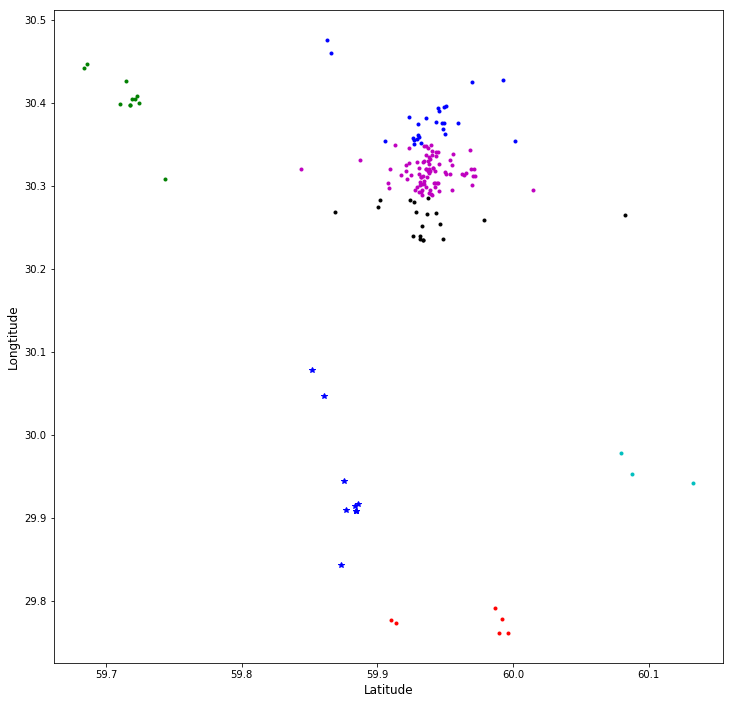

In [169]:
#plot result
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longtitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(cf.Latitude[cluster].values,cf.Longtitude[cluster].values,ptsymb[i])
plt.show()

In [170]:
# create map of Sankt_petersburg using latitude and longitude values with clusters full
map_spb = folium.Map(location=[latitude, longitude], zoom_start=9)
ptsymb = np.array( ['red', 'blue', 'green', 'purple', 'orange', 'white', 'darkpurple', 'black'])
# add markers to map
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    try:
            for lat, lng in zip(cf.Latitude[cluster].values,cf.Longtitude[cluster]):
                folium.CircleMarker(
                [lat, lng],
                radius=5,
                color=ptsymb[i],
                fill=True,
                fill_color=ptsymb[i],
                fill_opacity=0.7,
                parse_html=False).add_to(map_spb)  
    except:
        continue
map_spb

In [124]:
#run KMeans for central data set
id_n=6
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(cc)
id_label=kmeans.labels_

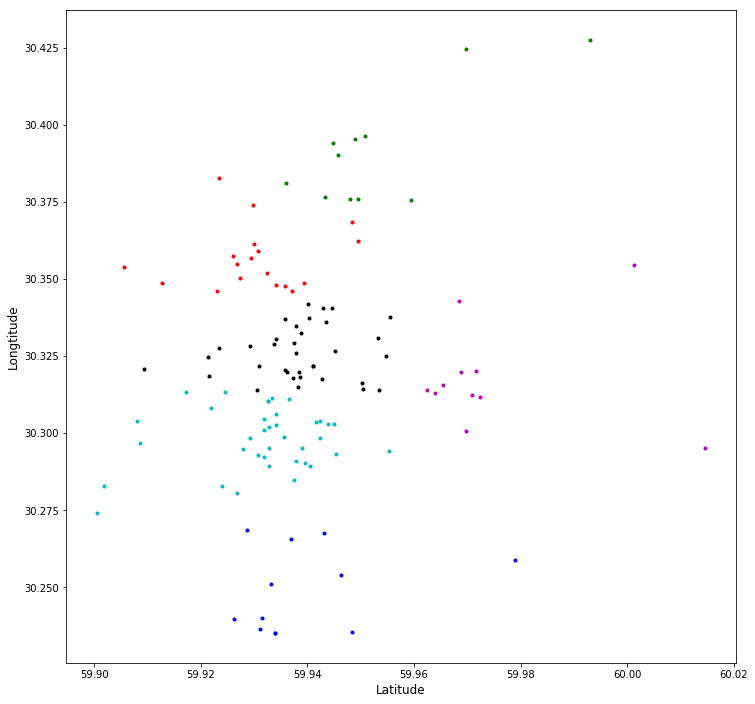

In [125]:
#plot result
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longtitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(cc.Latitude[cluster].values,cc.Longtitude[cluster].values,ptsymb[i])
plt.show()

In [126]:
# create map of Sankt_petersburg using latitude and longitude values with clusters center
map_spb = folium.Map(location=[latitude, longitude], zoom_start=12)
ptsymb = np.array( ['red', 'blue', 'green', 'purple', 'orange', 'white', 'pink', 'black'])
# add markers to map
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    for lat, lng in zip(cc.Latitude[cluster].values,cc.Longtitude[cluster]):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=ptsymb[i],
        fill=True,
        fill_color=ptsymb[i],
        fill_opacity=0.7,
        parse_html=False).add_to(map_spb)  
    
map_spb

#### Now taht we made clustering for both data frames, for our futher analysis we will focus only on Sankt-Petersburg internal museums without satelites, because to compare hotel density between satelites clusters and city clusters is not meanungfull.

In [130]:
# Lets make df for  data sets cultural cluster points
df_cc = pd.DataFrame({'Name':['Cluster_red','Cluster_blue','Cluster_green','Cluster_purple','Cluster_orange','Cluster_white'],
                     'Latitude_c':[0,0,0,0,0,0],
                     'Longtitude_c':[0,0,0,0,0,0],
                     })


In [134]:
df_cc.loc[0,'Latitude_c'] = 59.938429
df_cc.loc[0,'Longtitude_c'] = 30.250873

df_cc.loc[1,'Latitude_c'] = 59.931362
df_cc.loc[1,'Longtitude_c'] = 30.360673

df_cc.loc[2,'Latitude_c'] = 59.968877
df_cc.loc[2,'Longtitude_c'] = 30.313806

df_cc.loc[3,'Latitude_c'] = 59.946464
df_cc.loc[3,'Longtitude_c'] = 30.390296

df_cc.loc[4,'Latitude_c'] = 59.932623
df_cc.loc[4,'Longtitude_c'] = 30.297246

df_cc.loc[5,'Latitude_c'] = 59.937696
df_cc.loc[5,'Longtitude_c'] = 30.326959


In [135]:
df_cc

,Name,Latitude_c,Longtitude_c
0,Cluster_red,59.938429,30.250873
1,Cluster_blue,59.931362,30.360673
2,Cluster_green,59.968877,30.313806
3,Cluster_purple,59.946464,30.390296
4,Cluster_orange,59.932623,30.297246
5,Cluster_white,59.937696,30.326959


### Part 3 Hotel Density Analysis  
### Methodology

In [136]:
# The code was removed by Watson Studio for sharing.

In [138]:
#Get the Cluster_red latitude and longitude values.
Cluster_red_latitude = df_cc.loc[0, 'Latitude_c'] #latitude value
Cluster_red_longitude = df_cc.loc[0, 'Longtitude_c'] #longitude value

Cluster_red_name = df_cc.loc[0, 'Name'] # name

print('Latitude and longitude values of {} are {}, {}.'.format(Cluster_red_name, 
                                                               Cluster_red_latitude, 
                                                               Cluster_red_longitude))

Latitude and longitude values of Cluster_red are 59.938429, 30.250873.


In [139]:
# Now, let's get the top 500 venues that are in Parkwoods within a radius of 2000 meters.
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 2000 # define radius

 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Cluster_red_latitude, 
    Cluster_red_longitude, 
    radius, 
    LIMIT)
# Send the GET request and examine the resutls
results = requests.get(url).json()

In [140]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [141]:
# Now lets clean the json and structure it into a pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# explore what we find
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

100 venues were returned by Foursquare.


,name,categories,lat,lng
0,СШОР №1 Василеостровского района,Volleyball Court,59.939254,30.248402
1,Оружейная Линия,Gun Shop,59.936249,30.254473
2,Erarta (Эрарта),Art Museum,59.932368,30.251383
3,Museum of Electrical Transport (Музей городско...,Museum,59.938932,30.260764
4,Прокат костюмов КапуSSта NZ,Costume Shop,59.933457,30.253923


In [144]:
#Let's create a function to repeat the same process to all the clusters
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cluster Name', 
                  'Latitude_c', 
                  'Longtitude_c', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [145]:
# Now write the code to run the above function on each cluster point and create a new dataframe called ny_venues.
spb_venues = getNearbyVenues(names=df_cc['Name'],
                                   latitudes=df_cc['Latitude_c'],
                                   longitudes=df_cc['Longtitude_c']
                                  )

Cluster_red
Cluster_blue
Cluster_green
Cluster_purple
Cluster_orange
Cluster_white


In [147]:
# Explore what we find
print(spb_venues.shape)
spb_venues.head()

(600, 7)


,Cluster Name,Latitude_c,Longtitude_c,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cluster_red,59.938429,30.250873,СШОР №1 Василеостровского района,59.939254,30.248402,Volleyball Court
1,Cluster_red,59.938429,30.250873,Оружейная Линия,59.936249,30.254473,Gun Shop
2,Cluster_red,59.938429,30.250873,Erarta (Эрарта),59.932368,30.251383,Art Museum
3,Cluster_red,59.938429,30.250873,Museum of Electrical Transport (Музей городско...,59.938932,30.260764,Museum
4,Cluster_red,59.938429,30.250873,Прокат костюмов КапуSSта NZ,59.933457,30.253923,Costume Shop


In [151]:
# Lets see how many venues each Cluster has
spb_venues.groupby('Cluster Name').count().loc[:,'Venue']

Cluster Name
Cluster_blue      100
Cluster_green     100
Cluster_orange    100
Cluster_purple    100
Cluster_red       100
Cluster_white     100
Name: Venue, dtype: int64

In [153]:
# Let's find out how many unique categories we have from all the returned venues
print('There are {} uniques categories.'.format(len(spb_venues['Venue Category'].unique())))

There are 152 uniques categories.


In [154]:
spb_venues['Venue Category'].unique()

array(['Volleyball Court', 'Gun Shop', 'Art Museum', 'Museum',
       'Costume Shop', 'Italian Restaurant', 'Park', 'Athletics & Sports',
       'Bakery', 'Gym Pool', 'Dessert Shop', 'Harbor / Marina',
       'Gas Station', 'Gymnastics Gym', 'Coffee Shop', 'Hookah Bar',
       'Music Venue', 'Art Gallery', 'Health Food Store',
       'Science Museum', 'Pilates Studio', 'Caucasian Restaurant',
       'Restaurant', 'Chinese Restaurant', 'Theater', 'Buffet',
       'Movie Theater', 'Burger Joint', 'Seafood Restaurant',
       'Waterfront', 'Boutique', 'Auto Workshop', 'Bed & Breakfast',
       'Arcade', 'Hotel', 'Wine Shop', 'Martial Arts Dojo',
       'Middle Eastern Restaurant', 'Vegetarian / Vegan Restaurant',
       'Gourmet Shop', 'Spa', 'Tea Room', 'Bar', 'Concert Hall',
       'Massage Studio', 'Dance Studio', 'Supermarket', 'Cosmetics Shop',
       'Lounge', 'Event Space', 'Arts & Crafts Store', 'Beer Store',
       'Photography Studio', 'History Museum', 'Yoga Studio',
       'IT

In [159]:
# one hot encoding
spb_onehot = pd.get_dummies(spb_venues[['Venue Category']], prefix="", prefix_sep="")

# add Cluster Name column back to dataframe
spb_onehot['Cluster Name'] = spb_venues['Cluster Name'] 

# move Cluster Name column to the first column
fixed_columns = [spb_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
spb_onehot = spb_onehot[fixed_columns]

spb_onehot.tail()

,Cluster Name,Cluster Name,Accessories Store,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Bath House,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Buffet,Burger Joint,Café,Camera Store,Canal,Caucasian Restaurant,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cycle Studio,Dance Studio,Design Studio,Dessert Shop,Dive Shop,Donut Shop,Drive-in Theater,Eastern European Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Pelmeni House,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,Public Art,Record Shop,Recording Studio,Restaurant,Roller Rink,Russian Restaurant,Salon / Barbershop,Salsa Club,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Skating Rink,Smoke Shop,Soccer Field,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Women's Store
595,Cluster_white,Cluster_white,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
596,Cluster_white,Cluster_white,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
597,Cluster_white,Cluster_white,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
598,Cluster_white,Cluster_white,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
599,Cluster_white,Cluster_white,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [160]:
# let's group rows by Cluster Name and by taking the mean of the frequency of occurrence of each category
spb_grouped = ny_onehot.groupby('Cluster Name').mean().reset_index()
pd.set_option('display.max_columns', 170)
spb_grouped

,Cluster Name,Accessories Store,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Bath House,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Buffet,Burger Joint,Café,Camera Store,Canal,Caucasian Restaurant,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cycle Studio,Dance Studio,Design Studio,Dessert Shop,Dive Shop,Donut Shop,Drive-in Theater,Eastern European Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Pelmeni House,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,Public Art,Record Shop,Recording Studio,Restaurant,Roller Rink,Russian Restaurant,Salon / Barbershop,Salsa Club,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Skating Rink,Smoke Shop,Soccer Field,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Cluster_blue,0.02,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.02,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.04,0.12,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.03,0.00,0.00,0.05,0.01,0.04,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.03,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.02,0.01,0.02,0.03
1,Cluster_green,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.00,0.01,0.01,0.00,0.01,0.01,0.00,0.04,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.00,0.01,0.00,0.01,0.02,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.02,0.00,0.01,0.00,0.00,0.02,0.00,0.02,0.01,0.01,0.00,0.01,0.00,0.01,0.05,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.01,0.00,0.00,0.00,0.02,0.02,0.00,0.01
2,Cluster_orange,0.00,0.03,0.00,0.04,0.00,0.01,0.00,0.00,0.00,0.05,0.03,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.04,0.00,0.01,0.02,0.01,0.01,0.00,0.00,0.03,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00

### Results

In [162]:
#Let's print each Cluster Name along with the top 5 most common venues
num_top_venues = 10

for hood in spb_grouped['Cluster Name']:
    print("----"+hood+"----")
    temp = spb_grouped[ny_grouped['Cluster Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cluster_blue----
                venue  freq
0         Coffee Shop  0.12
1              Bakery  0.08
2          Hookah Bar  0.05
3               Hotel  0.04
4        Cocktail Bar  0.04
5           Bookstore  0.04
6  Italian Restaurant  0.03
7                 Bar  0.03
8                 Spa  0.03
9             Theater  0.03


----Cluster_green----
                venue  freq
0         Coffee Shop  0.07
1          Restaurant  0.05
2          Hookah Bar  0.04
3    Botanical Garden  0.04
4             Theater  0.03
5           Gastropub  0.03
6  Salon / Barbershop  0.03
7              Bakery  0.03
8                 Bar  0.03
9        Dance Studio  0.03


----Cluster_orange----
            venue  freq
0           Hotel  0.09
1          Bakery  0.05
2      Art Museum  0.04
3            Café  0.04
4      Restaurant  0.04
5    Concert Hall  0.04
6          Arcade  0.03
7           Plaza  0.03
8  Clothing Store  0.03
9            Park  0.03


----Cluster_purple----
                  venue  

In [163]:
#Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [165]:
# Now let's create the new dataframe and display the top 10 venues for each clusters.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clusters_venues_sorted = pd.DataFrame(columns=columns)
clusters_venues_sorted['Cluster Name'] = spb_grouped['Cluster Name']

for ind in np.arange(spb_grouped.shape[0]):
    clusters_venues_sorted.iloc[ind, 1:] = return_most_common_venues(spb_grouped.iloc[ind, :], num_top_venues)

clusters_venues_sorted

,Cluster Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cluster_blue,Coffee Shop,Bakery,Hookah Bar,Bookstore,Cocktail Bar,Hotel,Spa,Bar,Health Food Store,Italian Restaurant
1,Cluster_green,Coffee Shop,Restaurant,Hookah Bar,Botanical Garden,Gastropub,Salon / Barbershop,Bakery,Bar,Theater,Dance Studio
2,Cluster_orange,Hotel,Bakery,Restaurant,Concert Hall,Café,Art Museum,Plaza,Park,Bar,Clothing Store
3,Cluster_purple,Bakery,Park,Italian Restaurant,Coffee Shop,Hookah Bar,Wine Bar,Café,Caucasian Restaurant,Health Food Store,Health & Beauty Service
4,Cluster_red,Bakery,Wine Shop,Park,Hotel,Restaurant,Dance Studio,Coffee Shop,Hookah Bar,Spa,Gastropub
5,Cluster_white,Theater,Hotel,Art Museum,Plaza,Garden,Arcade,Dance Studio,Spa,Hostel,Park


### Discussion

1. As we can see, only one Cultural Cluster Center at all has Hostel as venue type, and it's in **_9th_** **_place!!!_** There are huge undersupply of Hostels in Sankt-Petersburg. Of course, I'm as a resident of Sankt-Petersburg know the reason. There are administration barriers which are in the way of Hostels. Unfortunately, that makes the Hotel industry less competitive.


2. Orange and White Cultural CLusters Centers have Hotel as Most Common Venue in **first and second place**, they are the most City-Center Clusters and its convenient to get to all others Clusters from them. 


3. The Red Cultural Center Cluster relative low **4th place** Hotel as Most Common Venue can be explained by the fact, that the island on which cluster is situated got only 2 bridges as main exists, and it's not convenient to get around.  


4. Blue Cultural Cluster Center despite its convenient location near main Train Station and proximity to Orange and White Clusters has **6th place** Hotel as Most Common Venue. There is no simple explanation to that. That also means that there is a room for improvement fro businesses. 


5. Purple and Green have **_no_** Hotel as Most Common Venue at all! That can be explained that the most popular Tourist venues are in more centric Clusters, but at least this clusters should be considered for Hostels, as relative to other clusters rent there is the cheapest.

### Conclusion

There is much asymmetry of information and inefficiencies in the Sankt-Petersburg Hotel market. Most of them are administrative. However, inefficiencies also mean opportunities, and according to my analysis, we were able to spot some of them.

First of all, the vast undersupply of Hostels, if someone has an administrative resource that might be a good business idea to open one or few in Purple or Green Cultural Centers Clusters.

Second underrepresentation of Hotels in blue Cultural Cluster Center, proximity to a City-Center and Main Railway Station are factors which are hard to undervalue.

In the end, for anyone who will look through this report, I hope that at least if not for business purposes, but you now know a bit more about my home town Sankt-Petersburg and his museums. How many out there and where they located. **:)**